1. My contribution mainly lies in extracting holiday features. 
2. I used Fitter to view the data distribution of the target column and used statistical indicators to check the deviation between predicted values and true values.
3. I haven't programmed for many years. I have been learning Python for the past few months, but I am still not very proficient. I have submitted many times. The parameters are not optimal, but I haven't submitted any more times today. If it is helpful, please upvote. Thanks to everyone.

In [29]:
!pip install -U --q /home/onyxia/work/Forecasting_Sticker_Sales/fitter-1.7.1-py3-none-any.whl
!pip install -U --q pycountry

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import holidays
import pycountry

from fitter import Fitter
from scipy import stats

SEED = 42
n_splits = 5
n_estimators=1000
early_stopping_rounds = 100
FE_holidays = True

In [31]:
train_data = pd.read_csv(r"/home/onyxia/work/Forecasting_Sticker_Sales/train.csv")
test_data = pd.read_csv(r"/home/onyxia/work/Forecasting_Sticker_Sales/test.csv")
data = pd.read_csv(r"/home/onyxia/work/Forecasting_Sticker_Sales/sample_submission.csv")

print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("data shape :",data.shape)

train_data shape : (230130, 6)
test_data shape : (98550, 5)
data shape : (98550, 2)


In [32]:
train_data.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [33]:
train_data.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [34]:
train_data.isna().sum().sort_values(ascending=False)

num_sold    8871
id             0
date           0
country        0
store          0
product        0
dtype: int64

In [35]:
train_data['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [36]:
train_data = train_data.drop_duplicates()
train_data = train_data.dropna()
print("train_data shape :",train_data.shape)

train_data shape : (221259, 6)


In [37]:
test_data.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [38]:
test_data.isna().sum().sort_values(ascending=False)

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [39]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['Year'] = train_data['date'].dt.year
train_data['Quarter'] = train_data['date'].dt.quarter
train_data['Month'] = train_data['date'].dt.month
train_data['Day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.day_name()
train_data['week_of_year'] = train_data['date'].dt.isocalendar().week

train_data['day_sin'] = np.sin(2 * np.pi * train_data['Day'] / 365.0)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['Day'] / 365.0)
train_data['month_sin'] = np.sin(2 * np.pi * train_data['Month'] / 12.0)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['Month'] / 12.0)
train_data['year_sin'] = np.sin(2 * np.pi * train_data['Year'] / 7.0)
train_data['year_cos'] = np.cos(2 * np.pi * train_data['Year'] / 7.0)
train_data['Group']=(train_data['Year']-2010)*48+train_data['Month']*4+train_data['Day']//7

test_data['Year'] = test_data['date'].dt.year
test_data['Quarter'] = test_data['date'].dt.quarter
test_data['Month'] = test_data['date'].dt.month
test_data['Day'] = test_data['date'].dt.day
test_data['day_of_week'] = test_data['date'].dt.day_name()
test_data['week_of_year'] = test_data['date'].dt.isocalendar().week

test_data['day_sin'] = np.sin(2 * np.pi * test_data['Day'] / 365.0)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['Day'] / 365.0)
test_data['month_sin'] = np.sin(2 * np.pi * test_data['Month'] / 12.0)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['Month'] / 12.0)
test_data['year_sin'] = np.sin(2 * np.pi * test_data['Year'] / 7.0)
test_data['year_cos'] = np.cos(2 * np.pi * test_data['Year'] / 7.0)
test_data['Group']=(test_data['Year']-2010)*48+test_data['Month']*4+test_data['Day']//7



In [40]:
train_data['Quarter'] = train_data['Quarter'].astype('str')
train_data['Month'] = train_data['Month'].astype('str')
train_data['day_of_week'] = train_data['day_of_week'].astype('str')
train_data['week_of_year'] = train_data['week_of_year'].astype('str')

test_data['Quarter'] = test_data['Quarter'].astype('str')
test_data['Month'] = test_data['Month'].astype('str')
test_data['day_of_week'] = test_data['day_of_week'].astype('str')
test_data['week_of_year'] = test_data['week_of_year'].astype('str')

In [41]:
def get_holiday_name(country_code, date_obj):
    country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'
    
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'
    
    return get_holiday_name(country_code, date_obj)

if FE_holidays:
    train_data['holidays_name'] = train_data.apply(get_holiday_for_row, axis=1)
    test_data['holidays_name'] = test_data.apply(get_holiday_for_row, axis=1)

In [42]:
print(train_data['holidays_name'].value_counts() )


holidays_name
New Year's Day                                 511
Christmas Day                                  510
Good Friday                                    500
Easter Monday                                  302
Labor Day                                      300
Second Day of Christmas                        210
Chinese New Year                               210
Easter Sunday                                  210
Whit Sunday                                    210
Ascension Day                                  195
Independence Day                               105
Midsummer Eve                                  105
Midsummer Day                                  105
Christmas Eve                                  105
Eid al-Fitr                                    105
National Day                                   105
Assunzione della Vergine                       105
Eid al-Adha                                    105
Festa della Repubblica                         105
Tutti i Santi    

In [43]:
train_data.drop('date',axis=1,inplace=True)
test_data.drop('date',axis=1,inplace=True)

In [44]:
print(train_data.info())

train_data = train_data.drop('id', axis = 1)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

print('num_cols:',num_cols)
print('cat_cols:',cat_cols)

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             221259 non-null  int64  
 1   country        221259 non-null  object 
 2   store          221259 non-null  object 
 3   product        221259 non-null  object 
 4   num_sold       221259 non-null  float64
 5   Year           221259 non-null  int32  
 6   Quarter        221259 non-null  object 
 7   Month          221259 non-null  object 
 8   Day            221259 non-null  int32  
 9   day_of_week    221259 non-null  object 
 10  week_of_year   221259 non-null  object 
 11  day_sin        221259 non-null  float64
 12  day_cos        221259 non-null  float64
 13  month_sin      221259 non-null  float64
 14  month_cos      221259 non-null  float64
 15  year_sin       221259 non-null  float64
 16  year_cos       221259 non-null  float64
 17  Group          221259 non-null  in

In [45]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    combined_data = pd.concat([train_data[col], test_data[col]])
    le = LabelEncoder()
    le.fit(combined_data)
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    

2025-01-02 22:44:37.577 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=6e-06)
2025-01-02 22:44:38.152 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3e-06)
2025-01-02 22:44:38.184 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=6e-06)
2025-01-02 22:44:38.394 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=4e-06)
2025-01-02 22:44:42.114 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=3e-06)


Distribution of original training data:


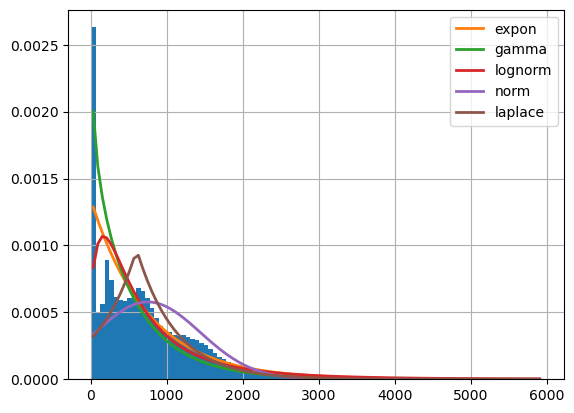

In [46]:
f = Fitter(train_data['num_sold'], distributions=['norm', 'lognorm', 'laplace', 'expon', 'gamma'])
f.fit()
print('Distribution of original training data:')
f.summary()
lognorm_params = f.fitted_param['lognorm']

In [47]:
from sklearn.model_selection import train_test_split
train_data['num_sold'] = np.log1p(train_data['num_sold'])
X = train_data.drop(['num_sold'], axis=1)
y = train_data['num_sold']
test = test_data.drop(['id'],axis=1)

# Split datainto training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))

In [49]:
kf = KFold(n_splits, shuffle=True, random_state=SEED)
kf_splits = kf.split(X)
scores1 = []
test_preds1 = []

lgbm_params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': n_estimators,
    'learning_rate': 0.08,
    'max_depth': 13,
    'reg_alpha': 0.01,
    'lambda_l2': 0.01,  
    'min_child_samples' : 32,
    'colsample_bytree': 0.93,
    'subsample': 0.7, 
    'seed': SEED,
    'verbose': -1,
    'device' : 'cpu' 
}

for i, (train_idx, val_idx) in enumerate(kf_splits):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    #train_lgbm_dataset = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=cat_cols)
    #valid_lgbm_dataset = lgb.Dataset(X_val_fold, label=y_val_fold, categorical_feature=cat_cols)
    
    callbacks = [lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)]
    model = lgb.LGBMRegressor(**lgbm_params1)
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], categorical_feature=cat_cols,eval_metric='rmse', callbacks=callbacks)
    
    val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration_)
    score = mape(y_val_fold, val_pred)
    scores1.append(score)
    
    test_pred = np.maximum(model.predict(test, num_iteration=model.best_iteration_),0)
    test_preds1.append(test_pred)
    
    print(f'LightGBM Fold {i + 1} mape: {score}')
print(f'LightGBM mape: {np.mean(scores1):.5f};');


LightGBM Fold 1 mape: 0.042908964349325576
LightGBM Fold 2 mape: 0.042871761413659504
LightGBM Fold 3 mape: 0.04308763213687475
LightGBM Fold 4 mape: 0.042921668035047086
LightGBM Fold 5 mape: 0.04288293188306569
LightGBM mape: 0.04293;


In [50]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_val_fold)
#shap.summary_plot(shap_values, X_val_fold,feature_names=X_val_fold.columns.tolist(), max_display=20,show=False)
#plt.title('SHAP Summary Plot')
#plt.xlabel('SHAP value (impact on model output)')
#plt.rcParams['font.size']=12
#plt.show()

In [51]:
#y_preds = (np.mean(test_preds1, axis=0)+np.mean(test_preds2, axis=0))/2
#y_preds = np.mean(test_preds1, axis=0)
y_preds = np.mean(test_preds1, axis=0)
y_preds = np.expm1(y_preds)

print('predict mean before:',y_preds.mean())
print('predict median before:',np.median(y_preds))
y_preds = y_preds*1.01
print('predict mean after:',y_preds.mean())
print('predict median after:',np.median(y_preds))

y_preds = np.clip(y_preds,5,5939)


predict mean before: 745.2572532186413
predict median before: 597.1282212387597
predict mean after: 752.7098257508275
predict median after: 603.0995034511473


2025-01-02 22:45:06.459 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=1e-05)
2025-01-02 22:45:06.460 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=1e-05)
2025-01-02 22:45:06.471 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=6e-06)
2025-01-02 22:45:06.629 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=7e-06)
2025-01-02 22:45:08.099 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=3e-06)


Distribution of predicting data:


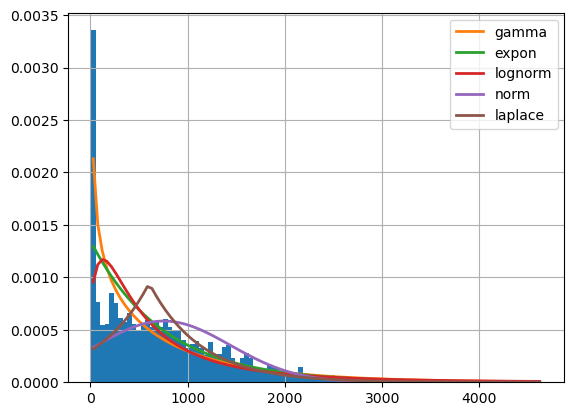

In [52]:
f = Fitter(y_preds, distributions=['norm', 'lognorm', 'laplace', 'expon', 'gamma'])
f.fit()
print('Distribution of predicting data:')
f.summary()   
norm_params = f.fitted_param['norm']

In [53]:
# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': y_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())

       id    num_sold
0  230130  120.910496
1  230131  936.152145
2  230132  758.115771
3  230133  420.739879
4  230134  497.073867
